In [1]:
import email
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import seaborn as sns; sns.set_style('whitegrid')
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# import pymongo
# from pymongo import MongoClient

## Load and Parse Data

In [41]:
#path_csv ="../Enron/Data/Archive/emails.csv"

In [42]:
# Don't need to run this from here till Exploratory Data Analysis now,  as  I saved the CSV of 10k rows and 18 columns 


#make a subset of the csv
total_rows = 517401
random_sample = 10000
lines_to_skip = np.random.choice(np.arange(1,total_rows+1), (total_rows-random_sample),replace=False)

df = pd.read_csv(path_csv, skiprows = lines_to_skip)

In [43]:
print(df.shape)
df.head()

(10000, 2)


,file,message
0,allen-p/_sent_mail/119.,Message-ID: <10523086.1075855687873.JavaMail.e...
1,allen-p/_sent_mail/213.,Message-ID: <21852423.1075855689918.JavaMail.e...
2,allen-p/_sent_mail/330.,Message-ID: <23985609.1075855692470.JavaMail.e...
3,allen-p/_sent_mail/446.,Message-ID: <21041312.1075855725847.JavaMail.e...
4,allen-p/_sent_mail/494.,Message-ID: <16552852.1075855726915.JavaMail.e...


In [3]:
path_csv = "C:\Users\Personal\Desktop\enron_usecase\emailsdf.csv"


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-3-56192a62b581>, line 1)

In [36]:
print(df.message[1])

Message-ID: <19034252.1075855687825.JavaMail.evans@thyme>
Date: Tue, 26 Sep 2000 09:28:00 -0700 (PDT)
From: phillip.allen@enron.com
To: kholst@enron.com
Subject: Investment Structure
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: kholst@enron.com
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 09/26/2000 
04:28 PM ---------------------------


"George Richards" <cbpres@austin.rr.com> on 09/26/2000 01:18:45 PM
Please respond to <cbpres@austin.rr.com>
To: "Phillip Allen" <pallen@enron.com>
cc: "Larry Lewter" <retwell@mail.sanmarcos.net>, "Claudia L. Crocker" 
<clclegal2@aol.com> 
Subject: Investment Structure


STRUCTURE:
Typically the structure is a limited partnership with a corporate (or LLC)
general partner.  The General Partner owns 1% of the project and carries the
liability of c

### Split CSV into multiple columns

In [44]:
## Helper functions
'''walk(): to iterate over all the parts and subparts of a message object tree, 
in depth-first traversal order. You will typically use walk() as the iterator in a for loop; 
each iteration returns the next subpart.

An email message consists of headers and a payload (which is also referred to as the content).'''


def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append(part.get_payload())
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [45]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, df['message']))
df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    df[key] = [doc[key] for doc in messages]
# Parse content from emails
df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
df['From'] = df['From'].map(split_email_addresses)
df['To'] = df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
df['user'] = df['file'].map(lambda x:x.split('/')[0])
del messages

df.head()


,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/119.,<10523086.1075855687873.JavaMail.evans@thyme>,"Tue, 26 Sep 2000 07:01:00 -0700 (PDT)",(phillip.allen@enron.com),(ina.rangel@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Ina Rangel,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p
1,allen-p/_sent_mail/213.,<21852423.1075855689918.JavaMail.evans@thyme>,"Mon, 17 Jul 2000 03:46:00 -0700 (PDT)",(phillip.allen@enron.com),(paul.lucci@enron.com),Comments on Order 637 Compliance Filings,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Paul T Lucci,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,fyi CIG\n\n---------------------- Forwarded b...,allen-p
2,allen-p/_sent_mail/330.,<23985609.1075855692470.JavaMail.evans@thyme>,"Mon, 31 Jan 2000 04:28:00 -0800 (PST)",(phillip.allen@enron.com),(julie.gomez@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Julie A Gomez,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Julie,\n\n The numbers for January are below:\...",allen-p
3,allen-p/_sent_mail/446.,<21041312.1075855725847.JavaMail.evans@thyme>,"Thu, 15 Mar 2001 06:11:00 -0800 (PST)",(phillip.allen@enron.com),(kim.bolton@enron.com),RE: PERSONAL AND CONFIDENTIAL COMPENSATION INF...,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Kim Bolton,,,\Phillip_Allen_June2001\Notes Folders\'sent mail,Allen-P,pallen.nsf,Thanks for the information. It would be helpf...,allen-p
4,allen-p/_sent_mail/494.,<16552852.1075855726915.JavaMail.evans@thyme>,"Tue, 20 Feb 2001 04:08:00 -0800 (PST)",(phillip.allen@enron.com),(stagecoachmama@hotmail.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,stagecoachmama@hotmail.com,,,\Phillip_Allen_June2001\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p


In [ ]:
df = df.set_index('Message-ID')\
    .drop(['Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

In [14]:
#change date dtype from object to datetime
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True,utc=True)

In [ ]:
#make tokens of the content column
df['tokens'] = df['content'].map(lambda r: word_tokenize(r))

## Exploratory Data Analysis 

In [27]:
#df.to_csv('emailsdf.csv')

path_csv = r'C:\Users\Personal\Desktop\enron_usecase\emailsdf.csv'

df = pd.read_csv(path_csv)

In [28]:
df.shape
df.head(2)

(10000, 16)

,Message-ID,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,tokens
0,<10523086.1075855687873.JavaMail.evans@thyme>,allen-p/_sent_mail/119.,2000-09-26 14:01:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'ina.rangel@enron.com'}),NaN,Phillip K Allen,Ina Rangel,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p,"['--', '--', '--', '--', '--', '--', '--', '--..."
1,<21852423.1075855689918.JavaMail.evans@thyme>,allen-p/_sent_mail/213.,2000-07-17 10:46:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'paul.lucci@enron.com'}),Comments on Order 637 Compliance Filings,Phillip K Allen,Paul T Lucci,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,fyi CIG\n\n---------------------- Forwarded b...,allen-p,"['fyi', 'CIG', '--', '--', '--', '--', '--', '..."


In [1]:
ax = df.groupby(df['Date'].dt.year)['content'].count().plot()

ax.set_xlabel('Year')
ax.set_ylabel('No. of Emails')

### Frequency of emails by year, month, day and hour

Text(0.5, 0, 'Day')

Text(0, 0.5, 'No. of Emails')

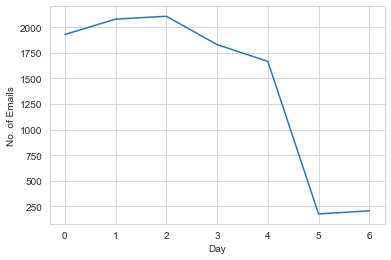

In [16]:
ax = df.groupby(df['Date'].dt.dayofweek)['content'].count().plot()

ax.set_xlabel('Day')
ax.set_ylabel('No. of Emails')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'No. of Emails')

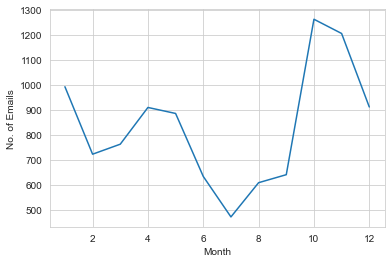

In [17]:
ax = df.groupby(df['Date'].dt.month)['content'].count().plot()

ax.set_xlabel('Month')
ax.set_ylabel('No. of Emails')

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'No. of Emails')

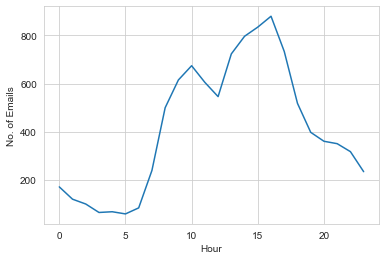

In [18]:
ax = df.groupby(df['Date'].dt.hour)['content'].count().plot()

ax.set_xlabel('Hour')
ax.set_ylabel('No. of Emails')

### Clean the content column

In [29]:
#cleaning content column
df['content'].fillna("", inplace=True)
df['content'] = df['content'].str.replace('\n\n', " ")


#forwarded by emails
df.content.str.contains('[- ]*Forwarded by').value_counts()

#A new email will always start with the tag 'subject:',
#function to remove all the text to the left of this tag, and only on the last 'subject:' 
#tag to remove all forwarded messages. Specific code:

# Cleaning content column
df['content'] = df['content'].str.rsplit('Subject: ').str[-1] 
df['content'] = df['content'].str.rsplit(' --------------------------- ').str[-1] 

df.content.str.contains('[- ]*Forwarded by').value_counts()


False    8023
True     1977
Name: content, dtype: int64

False    9964
True       36
Name: content, dtype: int64

In [30]:
df.content.head()

0    Gas Trading Vision mtg. This meeting has been ...
1    Comments on Order 637 Compliance Filings \n\t ...
2    Julie,  The numbers for January are below:   A...
3    Thanks for the information.  It would be helpf...
4     Lucy, Thanks for clearing up the 2/2 file.  M...
Name: content, dtype: object

### Cleaning email address

In [31]:
# Cleaning email addresses
# need to fix 'To' email address 

df['From'] = df['From'].map(lambda x: x.lstrip("frozenset"))
# df['To'] = df['To'].map(lambda x: x.lstrip("frozenset"))
df['From'] = df['From'].str.strip("<\>(/){?}[:]*, ")
df['To'] = df['To'].str.strip("<\>(/){?}[:]*, ")
df['From'] = df['From'].str.replace("'", "")
df['To'] = df['To'].str.replace("'", "")
df['From'] = df['From'].str.replace('"', "")
df['To'] = df['To'].str.replace('"', "")

In [32]:
df['From'].head()
df['To'].head()

0    phillip.allen@enron.com
1    phillip.allen@enron.com
2    phillip.allen@enron.com
3    phillip.allen@enron.com
4    phillip.allen@enron.com
Name: From, dtype: object

0          frozenset({ina.rangel@enron.com
1          frozenset({paul.lucci@enron.com
2         frozenset({julie.gomez@enron.com
3          frozenset({kim.bolton@enron.com
4    frozenset({stagecoachmama@hotmail.com
Name: To, dtype: object

### Count of to and from emails

In [33]:
count_to =df.groupby('X-From').count() 
count_to.sort_values(by = ['content'], ascending = False).head(5)

,Message-ID,file,Date,From,To,Subject,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,tokens
X-From,,,,,,,,,,,,,,,
Kay Mann,339,339,339,339,339,330,339,53,0,339,339,339,339,339,339
Vince J Kaminski,273,273,273,273,272,255,272,88,0,273,273,273,273,273,273
Jeff Dasovich,175,175,175,175,175,159,175,34,0,175,175,175,175,175,175
Enron Announcements,148,148,148,148,148,148,148,2,0,148,148,148,148,148,148
Tana Jones,147,147,147,147,145,147,147,46,0,147,147,147,147,147,147


In [71]:
count_to =df.groupby('X-To').count() 
count_to.sort_values(by = ['content'], ascending = False).head(5)

,Message-ID,file,Date,From,To,Subject,X-From,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,tokens
X-To,,,,,,,,,,,,,,,
pete.davis@enron.com,110,110,110,110,110,110,110,110,0,110,110,110,110,110,110
vkaminski@aol.com,89,89,89,89,89,77,89,0,0,89,89,89,89,89,89
Tana Jones,88,88,88,88,88,88,88,29,0,88,88,88,88,88,88
"Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PDAVIS1>",70,70,70,70,70,70,70,70,0,70,70,47,70,70,70
Steven J Kean,58,58,58,58,58,56,58,18,0,58,58,58,58,58,58


### Some text mining

In [34]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Personal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Personal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [118]:
df['content']

0       ---------------------- Forwarded by Phillip K ...
1       fyi  CIG ---------------------- Forwarded by P...
2       Julie,  The numbers for January are below:   A...
3       Thanks for the information.  It would be helpf...
4       ---------------------- Forwarded by Phillip K ...
                              ...                        
9995      -----Original Message-----\nFrom: \tGreeniza...
9996      -----Original Message-----\nFrom: \t"Ritter,...
9997    Does this information reflect the additions of...
9998    WOW, that was higher than I thought.  That is ...
9999      -----Original Message-----\nFrom: \tMilnthor...
Name: content, Length: 10000, dtype: object

In [95]:
df_str = repr(df.content)
df_str

'0       ---------------------- Forwarded by Phillip K ...\n1       fyi  CIG ---------------------- Forwarded by P...\n2       Julie,  The numbers for January are below:   A...\n3       Thanks for the information.  It would be helpf...\n4       ---------------------- Forwarded by Phillip K ...\n                              ...                        \n9995      -----Original Message-----\\nFrom: \\tGreeniza...\n9996      -----Original Message-----\\nFrom: \\t"Ritter,...\n9997    Does this information reflect the additions of...\n9998    WOW, that was higher than I thought.  That is ...\n9999      -----Original Message-----\\nFrom: \\tMilnthor...\nName: content, Length: 10000, dtype: object'

In [94]:
sentences = sent_tokenize(df_str)
sentences

['0       ---------------------- Forwarded by Phillip K ...\n1       fyi  CIG ---------------------- Forwarded by P...\n2       Julie,  The numbers for January are below:   A...\n3       Thanks for the information.',
 'It would be helpf...\n4       ---------------------- Forwarded by Phillip K ...\n                              ...                        \n9995      -----Original Message-----\\nFrom: \\tGreeniza...\n9996      -----Original Message-----\\nFrom: \\t"Ritter,...\n9997    Does this information reflect the additions of...\n9998    WOW, that was higher than I thought.',
 'That is ...\n9999      -----Original Message-----\\nFrom: \\tMilnthor...\nName: content, Length: 10000, dtype: object']

In [96]:
import string
string.punctuation
content = "".join(sentences).replace('\\n', " ").replace('\\t', " ").replace('\n', " ")
for d in string.punctuation: 
    content=content.replace(d, " ")
content

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

'0                              Forwarded by Phillip K     1       fyi  CIG                        Forwarded by P    2       Julie   The numbers for January are below    A    3       Thanks for the information It would be helpf    4                              Forwarded by Phillip K                                                               9995           Original Message      From   Greeniza    9996           Original Message      From    Ritter     9997    Does this information reflect the additions of    9998    WOW  that was higher than I thought That is     9999           Original Message      From   Milnthor    Name  content  Length  10000  dtype  object'

In [102]:
words = word_tokenize(content) 
words[0:10]

['0', 'Forwarded', 'by', 'Phillip', 'K', '1', 'fyi', 'CIG', 'Forwarded', 'by']

In [104]:
cust_stop_words = set(stopwords.words('english')+list(punctuation)) # stop words + punctuation

In [105]:
filtered_words = [word for sent in words for word in word_tokenize(sent) if word.lower() not in cust_stop_words]
filtered_words[0:10]

['0', 'Forwarded', 'Phillip', 'K', '1', 'fyi', 'CIG', 'Forwarded', 'P', '2']

In [117]:
fw_freq = nltk.FreqDist(filtered_words).most_common() # using nltk to get word frequencies
fw_freq[0:10]

from collections import Counter 
Counter(fw_freq).most_common(10)

[('Forwarded', 3),
 ('Original', 3),
 ('Message', 3),
 ('Phillip', 2),
 ('K', 2),
 ('information', 2),
 ('0', 1),
 ('1', 1),
 ('fyi', 1),
 ('CIG', 1)]

[(('Forwarded', 3), 1),
 (('Original', 3), 1),
 (('Message', 3), 1),
 (('Phillip', 2), 1),
 (('K', 2), 1),
 (('information', 2), 1),
 (('0', 1), 1),
 (('1', 1), 1),
 (('fyi', 1), 1),
 (('CIG', 1), 1)]

## Sentiment Analysis with Vader 
VADER generates positive, negative, and neutral sentiment scores for a given input

VADER collects and scores negative, neutral, and positive words and features (and accounts for factors like negation along the way). The “neg”, “neu”, and “pos” values describe the fraction of weighted scores that fall into each category. VADER also sums all weighted scores to calculate a “compound” value normalized between -1 and 1; this value attempts to describe the overall affect of the entire text from strongly negative (-1) to strongly positive (1).

In [6]:
message_text = """It seems to me we are in the middle of no man's land with respect to the
following:  Opec production speculation, Mid east crisis and renewed
tensions, US elections and what looks like a slowing economy  (?),  and no
real weather anywhere in the world.  I think it would be most prudent to play
the markets from a very flat price position and try to day trade more
aggressively.  I have no intentions of outguessing Mr. Greenspan, the US.
electorate, the Opec ministers and their new important roles, The Israeli and
Palestinian leaders, and somewhat importantly, Mother Nature.  Given that,
and that we cannot afford to lose any more money, and that Var seems to be a
problem, let's be as flat as possible. I'm ok with spread risk  (not front to
backs, but commodity spreads).


The morning meetings are not inspiring, and I don't have a real feel for
everyone's passion with respect to the markets.  As such, I'd like to ask
John N. to run the morning meetings on Mon. and Wed.

Thanks.   Jeff"""

In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
from nltk import word_tokenize
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Personal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
scores = sid.polarity_scores(message_text)
# scores

for key in sorted(scores):
        print('{0}: {1}, '.format(key, scores[key]), end='')

compound: 0.889, neg: 0.096, neu: 0.765, pos: 0.14, 

In [19]:
#The tokenize method breaks up the paragraph into a list of strings.

sentences = tokenizer.tokenize(message_text)

# We add the additional step of iterating through the list of
#sentences and calculating and printing polarity scores for each one.

for sentence in sentences:
        print(sentence)

for sentence in sentences:
        print(sentence)
        scores = sid.polarity_scores(sentence)
        for key in sorted(scores):
                print('{0}: {1}, '.format(key, scores[key]), end='')
        print()

It seems to me we are in the middle of no man's land with respect to the
following:  Opec production speculation, Mid east crisis and renewed
tensions, US elections and what looks like a slowing economy  (?
),  and no
real weather anywhere in the world.
I think it would be most prudent to play
the markets from a very flat price position and try to day trade more
aggressively.
I have no intentions of outguessing Mr. Greenspan, the US.
electorate, the Opec ministers and their new important roles, The Israeli and
Palestinian leaders, and somewhat importantly, Mother Nature.
Given that,
and that we cannot afford to lose any more money, and that Var seems to be a
problem, let's be as flat as possible.
I'm ok with spread risk  (not front to
backs, but commodity spreads).
The morning meetings are not inspiring, and I don't have a real feel for
everyone's passion with respect to the markets.
As such, I'd like to ask
John N. to run the morning meetings on Mon.
and Wed.
Thanks.
Jeff
It seems to 

In [40]:
# for con in df.content:
#     sentiments = []
#     for sent in con.split('.'):
#         print(type(sent), sent)
#         tokenized_sent = tokenizer.tokenize(sent)
#         sentiments.append(sid.polarity_scores(tokenized_sent))
#     print(sentiments)        
        
# # #         df['score'] = df['content'].apply(lambda: sid.polarity_scores(review))


df['scores'] = df['content'].apply(lambda content: sid.polarity_scores(content))

df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df.head()

df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c>0 else 'neu' if c==0 else 'neg')


# sentences = tokenizer.tokenize(message_text)

# # We add the additional step of iterating through the list of
# #sentences and calculating and printing polarity scores for each one.

# for sentence in sentences:
#         print(sentence)

# for sentence in sentences:
#         print(sentence)
#         scores = sid.polarity_scores(sentence)
#         for key in sorted(scores):
#                 print('{0}: {1}, '.format(key, scores[key]), end='')
#         print()

,Message-ID,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,tokens,scores,compound
0,<10523086.1075855687873.JavaMail.evans@thyme>,allen-p/_sent_mail/119.,2000-09-26 14:01:00+00:00,phillip.allen@enron.com,frozenset({ina.rangel@enron.com,NaN,Phillip K Allen,Ina Rangel,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Gas Trading Vision mtg. This meeting has been ...,allen-p,"['--', '--', '--', '--', '--', '--', '--', '--...","{'neg': 0.092, 'neu': 0.821, 'pos': 0.087, 'co...",-0.0644
1,<21852423.1075855689918.JavaMail.evans@thyme>,allen-p/_sent_mail/213.,2000-07-17 10:46:00+00:00,phillip.allen@enron.com,frozenset({paul.lucci@enron.com,Comments on Order 637 Compliance Filings,Phillip K Allen,Paul T Lucci,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Comments on Order 637 Compliance Filings \n\t ...,allen-p,"['fyi', 'CIG', '--', '--', '--', '--', '--', '...","{'neg': 0.0, 'neu': 0.944, 'pos': 0.056, 'comp...",0.3680
2,<23985609.1075855692470.JavaMail.evans@thyme>,allen-p/_sent_mail/330.,2000-01-31 12:28:00+00:00,phillip.allen@enron.com,frozenset({julie.gomez@enron.com,NaN,Phillip K Allen,Julie A Gomez,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Julie, The numbers for January are below: A...",allen-p,"['Julie', ',', 'The', 'numbers', 'for', 'Janua...","{'neg': 0.054, 'neu': 0.835, 'pos': 0.112, 'co...",0.5099
3,<21041312.1075855725847.JavaMail.evans@thyme>,allen-p/_sent_mail/446.,2001-03-15 14:11:00+00:00,phillip.allen@enron.com,frozenset({kim.bolton@enron.com,RE: PERSONAL AND CONFIDENTIAL COMPENSATION INF...,Phillip K Allen,Kim Bolton,NaN,NaN,\Phillip_Allen_June2001\Notes Folders\'sent mail,Allen-P,pallen.nsf,Thanks for the information. It would be helpf...,allen-p,"['Thanks', 'for', 'the', 'information', '.', '...","{'neg': 0.076, 'neu': 0.739, 'pos': 0.186, 'co...",0.8268
4,<16552852.1075855726915.JavaMail.evans@thyme>,allen-p/_sent_mail/494.,2001-02-20 12:08:00+00:00,phillip.allen@enron.com,frozenset({stagecoachmama@hotmail.com,NaN,Phillip K Allen,stagecoachmama@hotmail.com,NaN,NaN,\Phillip_Allen_June2001\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Lucy, Thanks for clearing up the 2/2 file. M...",allen-p,"['--', '--', '--', '--', '--', '--', '--', '--...","{'neg': 0.099, 'neu': 0.773, 'pos': 0.129, 'co...",0.5705


,Message-ID,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,tokens,scores,compound,comp_score
0,<10523086.1075855687873.JavaMail.evans@thyme>,allen-p/_sent_mail/119.,2000-09-26 14:01:00+00:00,phillip.allen@enron.com,frozenset({ina.rangel@enron.com,NaN,Phillip K Allen,Ina Rangel,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Gas Trading Vision mtg. This meeting has been ...,allen-p,"['--', '--', '--', '--', '--', '--', '--', '--...","{'neg': 0.092, 'neu': 0.821, 'pos': 0.087, 'co...",-0.0644,neg
1,<21852423.1075855689918.JavaMail.evans@thyme>,allen-p/_sent_mail/213.,2000-07-17 10:46:00+00:00,phillip.allen@enron.com,frozenset({paul.lucci@enron.com,Comments on Order 637 Compliance Filings,Phillip K Allen,Paul T Lucci,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Comments on Order 637 Compliance Filings \n\t ...,allen-p,"['fyi', 'CIG', '--', '--', '--', '--', '--', '...","{'neg': 0.0, 'neu': 0.944, 'pos': 0.056, 'comp...",0.3680,pos
2,<23985609.1075855692470.JavaMail.evans@thyme>,allen-p/_sent_mail/330.,2000-01-31 12:28:00+00:00,phillip.allen@enron.com,frozenset({julie.gomez@enron.com,NaN,Phillip K Allen,Julie A Gomez,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Julie, The numbers for January are below: A...",allen-p,"['Julie', ',', 'The', 'numbers', 'for', 'Janua...","{'neg': 0.054, 'neu': 0.835, 'pos': 0.112, 'co...",0.5099,pos
3,<21041312.1075855725847.JavaMail.evans@thyme>,allen-p/_sent_mail/446.,2001-03-15 14:11:00+00:00,phillip.allen@enron.com,frozenset({kim.bolton@enron.com,RE: PERSONAL AND CONFIDENTIAL COMPENSATION INF...,Phillip K Allen,Kim Bolton,NaN,NaN,\Phillip_Allen_June2001\Notes Folders\'sent mail,Allen-P,pallen.nsf,Thanks for the information. It would be helpf...,allen-p,"['Thanks', 'for', 'the', 'information', '.', '...","{'neg': 0.076, 'neu': 0.739, 'pos': 0.186, 'co...",0.8268,pos
4,<16552852.1075855726915.JavaMail.evans@thyme>,allen-p/_sent_mail/494.,2001-02-20 12:08:00+00:00,phillip.allen@enron.com,frozenset({stagecoachmama@hotmail.com,NaN,Phillip K Allen,stagecoachmama@hotmail.com,NaN,NaN,\Phillip_Allen_June2001\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Lucy, Thanks for clearing up the 2/2 file. M...",allen-p,"['--', '--', '--', '--', '--', '--', '--', '--...","{'neg': 0.099, 'neu': 0.773, 'pos': 0.129, 'co...",0.5705,pos


In [41]:
df.head(2)


,Message-ID,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,tokens,scores,compound,comp_score
0,<10523086.1075855687873.JavaMail.evans@thyme>,allen-p/_sent_mail/119.,2000-09-26 14:01:00+00:00,phillip.allen@enron.com,frozenset({ina.rangel@enron.com,NaN,Phillip K Allen,Ina Rangel,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Gas Trading Vision mtg. This meeting has been ...,allen-p,"['--', '--', '--', '--', '--', '--', '--', '--...","{'neg': 0.092, 'neu': 0.821, 'pos': 0.087, 'co...",-0.0644,neg
1,<21852423.1075855689918.JavaMail.evans@thyme>,allen-p/_sent_mail/213.,2000-07-17 10:46:00+00:00,phillip.allen@enron.com,frozenset({paul.lucci@enron.com,Comments on Order 637 Compliance Filings,Phillip K Allen,Paul T Lucci,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Comments on Order 637 Compliance Filings \n\t ...,allen-p,"['fyi', 'CIG', '--', '--', '--', '--', '--', '...","{'neg': 0.0, 'neu': 0.944, 'pos': 0.056, 'comp...",0.3680,pos


In [51]:
#to see if anyone resigned

df['Subject'].fillna("", inplace=True)

df[df['Subject'].str.contains(r'resignation|Good Bye|Bye|bye|goodbye|termination|terminate|GoodBye|resigning')]

,Message-ID,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,tokens,scores,compound,comp_score
203,<13776846.1075861105105.JavaMail.evans@thyme>,bailey-s/deleted_items/119.,2002-01-28 19:57:16+00:00,susan.bailey@enron.com,frozenset({kay.mann@enron.com,RE: Midland Cogeneration Venture termination,"Bailey, Susan </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Mann, Kay </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Kmann>",NaN,NaN,"\Susan_Bailey_Mar2002\Bailey, Susan\Deleted Items",Bailey-S,sbaile2 (Non-Privileged).pst,"Kay, Will deliver to you shortly. Susan ----...",bailey-s,"['Kay', ',', 'Will', 'deliver', 'to', 'you', '...","{'neg': 0.043, 'neu': 0.89, 'pos': 0.066, 'com...",0.2500,pos
1297,<4232947.1075852560694.JavaMail.evans@thyme>,dasovich-j/deleted_items/827.,2001-10-22 18:38:58+00:00,schub@socrates.berkeley.edu,"frozenset({eveningmba@haas.berkeley.edu, allph...",Correction of misstatement regarding Dean Tyso...,Marybeth Schubert <schub@socrates.berkeley.edu>,"staff@haas.berkeley.edu, mba02@haas.berkeley.e...",NaN,NaN,\JDASOVIC (Non-Privileged)\Deleted Items,Shankman-J,JSHANKM (Non-Privileged).pst,Dear Members of the Haas Community: As I'm sur...,dasovich-j,"['Dear', 'Members', 'of', 'the', 'Haas', 'Comm...","{'neg': 0.037, 'neu': 0.926, 'pos': 0.037, 'co...",0.0408,pos
2292,<8872287.1075849797404.JavaMail.evans@thyme>,gay-r/all_documents/81.,2000-12-20 16:50:00+00:00,rob.gay@enron.com,frozenset({richard.lammers@enron.com,Re: Conference call with Shell to Discuss Vent...,Rob G Gay,Richard A Lammers,NaN,NaN,\Randall_Gay_Nov2001\Notes Folders\All documents,GAY-R,rgay.nsf,Re: Conference call with Shell to Discuss Vent...,gay-r,"['I', ""'m"", 'going', 'to', 'try', 'and', 'catc...","{'neg': 0.0, 'neu': 0.882, 'pos': 0.118, 'comp...",0.6705,pos
4828,<20943478.1075840183261.JavaMail.evans@thyme>,keiser-k/inbox/159.,2002-01-29 20:59:11+00:00,c..gossett@enron.com,frozenset({kam.keiser@enron.com,FW: terminated vs non-terminated - request,"Gossett, Jeffrey C. </O=ENRON/OU=NA/CN=RECIPIE...","Keiser, Kam </O=ENRON/OU=NA/CN=RECIPIENTS/CN=K...",NaN,NaN,"\ExMerge - Keiser, Kam\Inbox",KEISER-K,kam keiser 7-11-02.PST,Enjoy. -----Original Message-----\nFrom: \tWi...,keiser-k,"['Enjoy', '.', '--', '--', '-Original', 'Messa...","{'neg': 0.018, 'neu': 0.888, 'pos': 0.094, 'co...",0.8316,pos
7905,<28416965.1075844733077.JavaMail.evans@thyme>,shackleton-s/all_documents/10528.,2001-04-13 11:25:00+00:00,sara.shackleton@enron.com,frozenset({ellen.su@enron.com,WestLB optional early termination language,Sara Shackleton,Ellen Su,Jorge A Garcia,NaN,\Sara_Shackleton_Dec2000_June2001_2\Notes Fold...,SHACKLETON-S,sshackle.nsf,Ellen: I've reviewed WestLB's optional early t...,shackleton-s,"['Ellen', ':', 'I', ""'ve"", 'reviewed', 'WestLB...","{'neg': 0.03, 'neu': 0.87, 'pos': 0.1, 'compou...",0.9625,pos
8095,<24188654.1075861057156.JavaMail.evans@thyme>,shackleton-s/inbox/638.,2002-01-29 16:23:24+00:00,brent.hendry@enron.com,frozenset({sara.shackleton@enron.com,FW: Updated Weather Counterparty that have ter...,"Hendry, Brent </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Shackleton, Sara </O=ENRON/OU=NA/CN=RECIPIENTS...",NaN,NaN,"\Sara_Shackleton_Mar2002\Shackleton, Sara\Inbox",Shackleton-S,sshackl (Non-Privileged).pst,"-----Original Message-----\nFrom: \tHendry, ...",shackleton-s,"['--', '--', '-Original', 'Message', '--', '--...","{'neg': 0.0, 'neu': 0.963, 'pos': 0.037, 'comp...",0.4404,pos


### Analyzing text with TF-IDF

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS


vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(df.content)

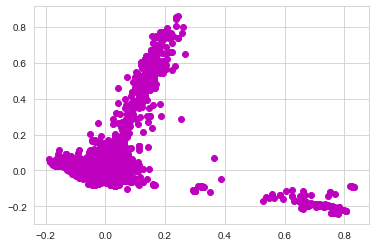

In [60]:
from sklearn.decomposition import PCA
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

                                         Message-ID  \
0     <10523086.1075855687873.JavaMail.evans@thyme>   
1     <21852423.1075855689918.JavaMail.evans@thyme>   
2     <23985609.1075855692470.JavaMail.evans@thyme>   
3     <21041312.1075855725847.JavaMail.evans@thyme>   
4     <16552852.1075855726915.JavaMail.evans@thyme>   
...                                             ...   
9995  <26306174.1075842032808.JavaMail.evans@thyme>   
9996  <20391686.1075842036339.JavaMail.evans@thyme>   
9997  <24698305.1075842036573.JavaMail.evans@thyme>   
9998   <6198978.1075842028789.JavaMail.evans@thyme>   
9999  <27114536.1075842029725.JavaMail.evans@thyme>   

                            file                       Date  \
0        allen-p/_sent_mail/119.  2000-09-26 14:01:00+00:00   
1        allen-p/_sent_mail/213.  2000-07-17 10:46:00+00:00   
2        allen-p/_sent_mail/330.  2000-01-31 12:28:00+00:00   
3        allen-p/_sent_mail/446.  2001-03-15 14:11:00+00:00   
4        allen-p/_sent_m